**Note: switch your runtime to GPU for fast training**

In [ ]:
%tensorflow_version 2.8.0
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.autograph.set_verbosity(0)

import keras
keras.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

# Using convnets to classify Cats vs. Dogs

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve
our network to reach an accuracy of 82%.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision
competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at:
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the
process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# Note: This is a very large dataset and will take time to download
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-05-25 03:02:10--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.216.167, 2600:1408:c400:128d::317f, 2600:1408:c400:1288::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.62.216.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   175MB/s    in 4.3s    

2023-05-25 03:02:14 (182 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



## Downsampling the data into folders
In this lab, we only use 2000 pictures for training (1K cats + 1K dogs), 1000 pictures for validation and 1000 pictures for testing. Also, we put the traning, validation and testing pictures into different folder so that the model can load the data accordingly.

In [ ]:
import shutil
import os

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = '/tmp/PetImages'

# The directory where we will
# store our smaller dataset
base_dir = '/tmp/cats_and_dogs_small'
if os.path.exists(base_dir):
  shutil.rmtree(base_dir)
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "Cat", fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "Cat", fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "Cat", fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "Dog", fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "Dog", fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, "Dog", fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

The 666th cat picture is corrupted with size 0, so we replace it with 2001st cat picture.

In [ ]:
! ls -lhrt /tmp/cats_and_dogs_small/train/cats/666.jpg

shutil.copyfile('/tmp/PetImages/Cat/2001.jpg', '/tmp/cats_and_dogs_small/train/cats/666.jpg')

! ls -lhrt /tmp/cats_and_dogs_small/train/cats/666.jpg

-rw-r--r-- 1 root root 0 May 25 03:02 /tmp/cats_and_dogs_small/train/cats/666.jpg
-rw-r--r-- 1 root root 21K May 25 03:02 /tmp/cats_and_dogs_small/train/cats/666.jpg


As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate
measure of success.

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we
will use here.  

We then leverage flow_from_directory to load images from `train_dir` and `validation_dir`, resize them into 150 x 150 images (height, width) and batch of 20 images.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# TODO: crate generator for data preprocessing.
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode = 'binary'
)
validation_generator = validation_datagen.flow_from_directory(
     train_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode = 'binary'
)


Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode = 'binary'
               )

Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop
at some point.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


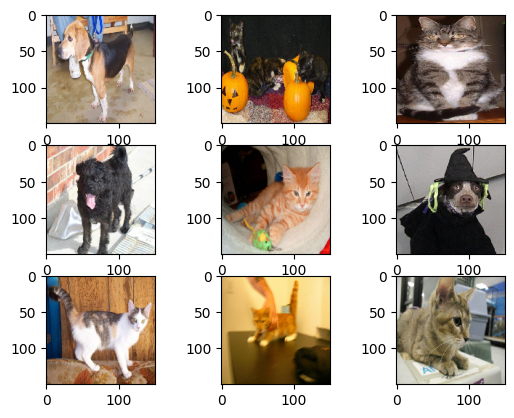

In [ ]:
from matplotlib import pyplot
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(data_batch[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

This code encodes cat label to 0 and dog label to 1

In [ ]:
labels_batch[:9]

array([1., 0., 0., 1., 0., 1., 0., 0., 0.], dtype=float32)

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.  
[Doc](https://keras.io/api/layers/convolution_layers/convolution2d/) for `Conv2D`  
[Doc](https://keras.io/api/layers/pooling_layers/max_pooling2d/) for `MaxPooling2D`


However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer. For each `Conv2D` layer, we used `kernel_size` of (3, 3), which means the reception field is 3 pixel by 3 pixel, and various number of the filters of the same size at different stage.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [ ]:
from keras import layers
from keras import models

# TODO: create a CNN with 4 convolution layers followed by a flatten layer and a fully connected hidden layer.
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters = 64, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters = 128, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters = 128, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation= 'relu'))
model.add(layers.Dense(1,activation= 'sigmoid')) #binry dense 1

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss. `RMSprop` means Root Mean Squared Propagation. It uses decaying moving average which allows the algorithm to forget early gradients and focus on the most recently observed partial gradients seen during the progress of the search

In [ ]:
# TODO model compile with loss and optimizer
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr = 0.001), metrics = ['accuracy'])

AttributeError: ignored

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])

Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does.
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case,
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument,
which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
# train model for 30 epochs
history = model.fit_generator(train_generator, steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps=50)

Epoch 1/30
100/100 [==============================] - 25s 135ms/step - loss: 0.7570 - accuracy: 0.5170 - val_loss: 0.6893 - val_accuracy: 0.5160
Epoch 2/30
100/100 [==============================] - 11s 109ms/step - loss: 0.7070 - accuracy: 0.5365 - val_loss: 0.6897 - val_accuracy: 0.5500
Epoch 3/30
100/100 [==============================] - 15s 153ms/step - loss: 0.6855 - accuracy: 0.5625 - val_loss: 0.6654 - val_accuracy: 0.6200
Epoch 4/30
100/100 [==============================] - 11s 110ms/step - loss: 0.6596 - accuracy: 0.6180 - val_loss: 0.6242 - val_accuracy: 0.6420
Epoch 5/30
100/100 [==============================] - 12s 119ms/step - loss: 0.6210 - accuracy: 0.6625 - val_loss: 0.5435 - val_accuracy: 0.7170
Epoch 6/30
100/100 [==============================] - 11s 104ms/step - loss: 0.5892 - accuracy: 0.6920 - val_loss: 0.5715 - val_accuracy: 0.7310
Epoch 7/30
100/100 [==============================] - 13s 132ms/step - loss: 0.5381 - accuracy: 0.7205 - val_loss: 0.4691 - val_ac

It is good practice to always save your models after training:

In [ ]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

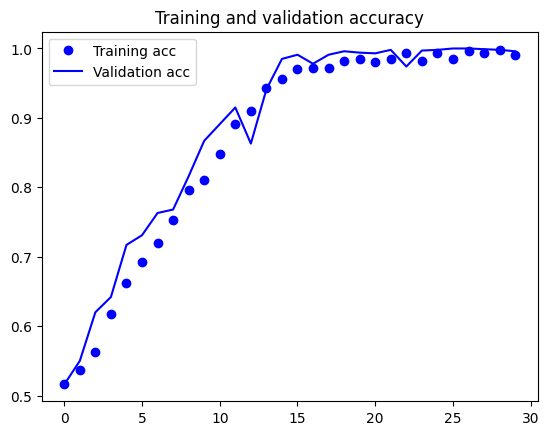

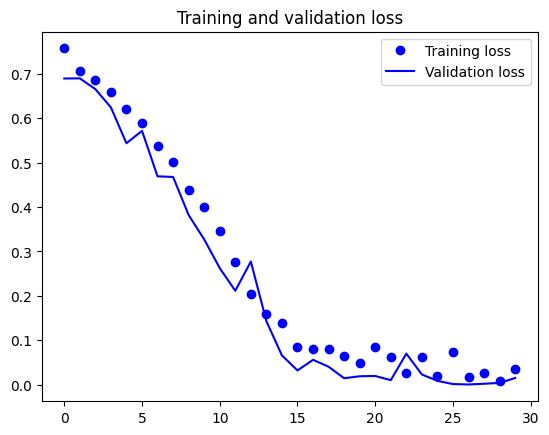

In [ ]:
e

In [ ]:
# TODO: evaluate model performance
model.evaluate_generator(test_generator,50)

[2.9873995780944824, 0.7089999914169312]

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data
augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator`
instance. Let's get started with an example:

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

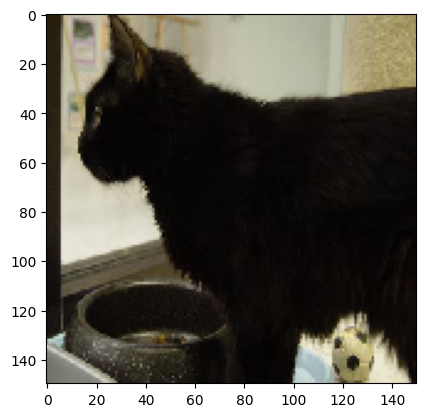

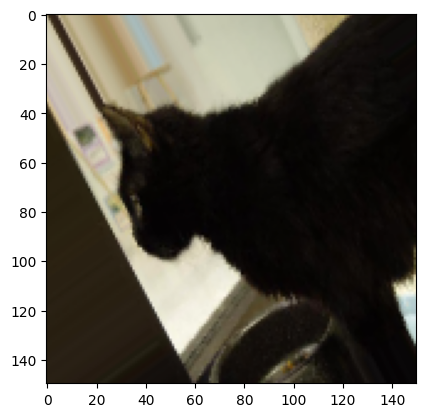

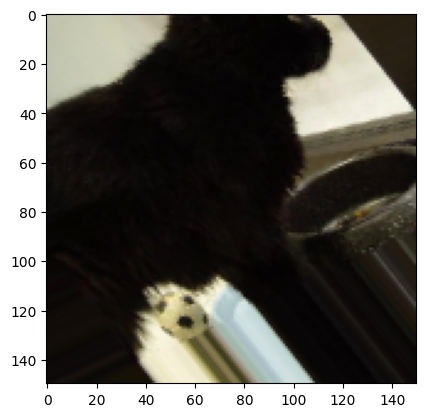

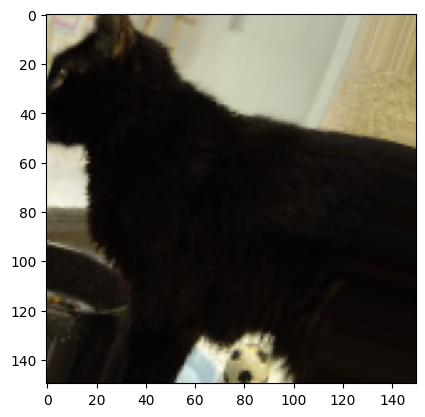

In [ ]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[0]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

plt.figure(0)
plt.imshow(img)

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 1
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information,
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(filters = 32, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Conv2D(filters = 64, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Conv2D(filters = 128, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Conv2D(filters = 128, kernel_size= (3,3),activation = 'relu', input_shape = (150,150,3)))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Flatten())

#new
model2.add(layers.Dropout(0.1))
model2.add(layers.Dense(512,activation= 'relu'))
model2.add(layers.Dense(1,activation= 'sigmoid')) #binry dense 1

Let's train our network using data augmentation and dropout:

In [ ]:
# TODO: crate generator for data preprocessing.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode = 'binary')


# TODO: train the model for 30 epochs

model2.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr = 0.001), metrics = ['accuracy'])
history = model2.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.


Epoch 1/30
100/100 [==============================] - 24s 222ms/step - loss: 0.7423 - accuracy: 0.5130 - val_loss: 0.6902 - val_accuracy: 0.5860
Epoch 2/30
100/100 [==============================] - 21s 214ms/step - loss: 0.6926 - accuracy: 0.5265 - val_loss: 0.6759 - val_accuracy: 0.5720
Epoch 3/30
100/100 [==============================] - 20s 200ms/step - loss: 0.6774 - accuracy: 0.5715 - val_loss: 0.6404 - val_accuracy: 0.6140
Epoch 4/30
100/100 [==============================] - 21s 214ms/step - loss: 0.6605 - accuracy: 0.5925 - val_loss: 0.6518 - val_accuracy: 0.5480
Epoch 5/30
100/100 [==============================] - 21s 213ms/step - loss: 0.6519 - accuracy: 0.6210 - val_loss: 0.6963 - val_accuracy: 0.5950
Epoch 6/30
100/100 [==============================] - 21s 215ms/step - loss: 0.6427 - accuracy: 0.6345 - val_loss: 0.6143 - val_accuracy: 0.6360
Epoch 7/30
100/100 [==============================] - 22s 222ms/step - loss: 0.6348 - accuracy: 0.6325 - val_loss: 0.6264 - val_ac

Let's save our model -- we will be using it in the section on convnet visualization.

In [ ]:
model2.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# TODO: evaluate model performance

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two
sections.

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model2.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

# Bonus point: Using a pre-trained CNN

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes).
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: **feature extraction** and **fine-tuning**. We will cover both of them. Let's start with feature extraction.

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
conv_base = tf.keras.applications.VGG16(weights = 'imagenet', include_top= False, input_shape(150,150,3))
model.add()

In [ ]:
model.summary()

As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized,
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model.
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

In [ ]:
 model.summary()

Instead of fine tuning all the layers of VGG, which is going to take a lot of time, let's only add last conv layer from VGG to layers to be fine tuned.

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv3':
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()